In [1]:
import numpy as np
import pandas as pd
import glob
from model.ctabgan import CTAB_XTRA_DP
df = pd.read_csv("datasets/adult.csv")
#df = df.drop(columns=['Year','Model'])

df = df.iloc[:, :4]
#df.loc[:7, 'capital-gain'] = np.nan
df = df.head(1000)
df

,age,workclass,fnlwgt,education
0,25,4,226802,1
1,38,4,89814,11
2,28,2,336951,7
3,44,4,160323,15
4,18,0,103497,15
...,...,...,...,...
995,17,4,28544,1
996,59,2,662460,0
997,22,4,152328,15
998,40,4,120277,9


In [2]:

synthesizer =  CTAB_XTRA_DP(df,
                 categorical_columns = ["workclass","education"], 
                 log_columns = {}, # Fuck this log, task for tommorrow
                 mixed_columns= {},
                 general_columns = [],
                 truncated_gaussian_columns=["age"],
                 integer_columns = [],
                 dp_constraints = {
                    "epsilon_budget": None,
                    "clip_coeff": None
                 }
                 ) 

In [3]:
synthesizer.fit(50)

Start training with 50 epochs
 5 critic iterations
 2 steps per epoch
 batch size 500


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


In [4]:
syn = synthesizer.generate_samples(1000)
syn.head(100)
syn.describe()


,age,workclass,fnlwgt,education
count,1000.00000,1000.00000,1000.000000,1000.00000
mean,37.96100,3.92600,187149.619000,9.76700
std,11.38284,1.77586,106358.780283,4.11967
min,18.00000,0.00000,-13552.000000,0.00000
25%,28.75000,4.00000,115020.500000,9.00000
50%,36.00000,4.00000,173616.500000,11.00000
75%,47.00000,5.00000,234270.500000,12.00000
max,70.00000,7.00000,671219.000000,15.00000


In [5]:
df.describe()

,age,workclass,fnlwgt,education
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,38.088000,3.887000,185524.965000,10.228000
std,13.712195,1.506154,100130.729371,3.958495
min,17.000000,0.000000,20308.000000,0.000000
25%,26.000000,4.000000,113226.000000,9.000000
50%,36.500000,4.000000,177493.000000,11.000000
75%,47.000000,4.000000,236861.000000,12.000000
max,90.000000,7.000000,662460.000000,15.000000


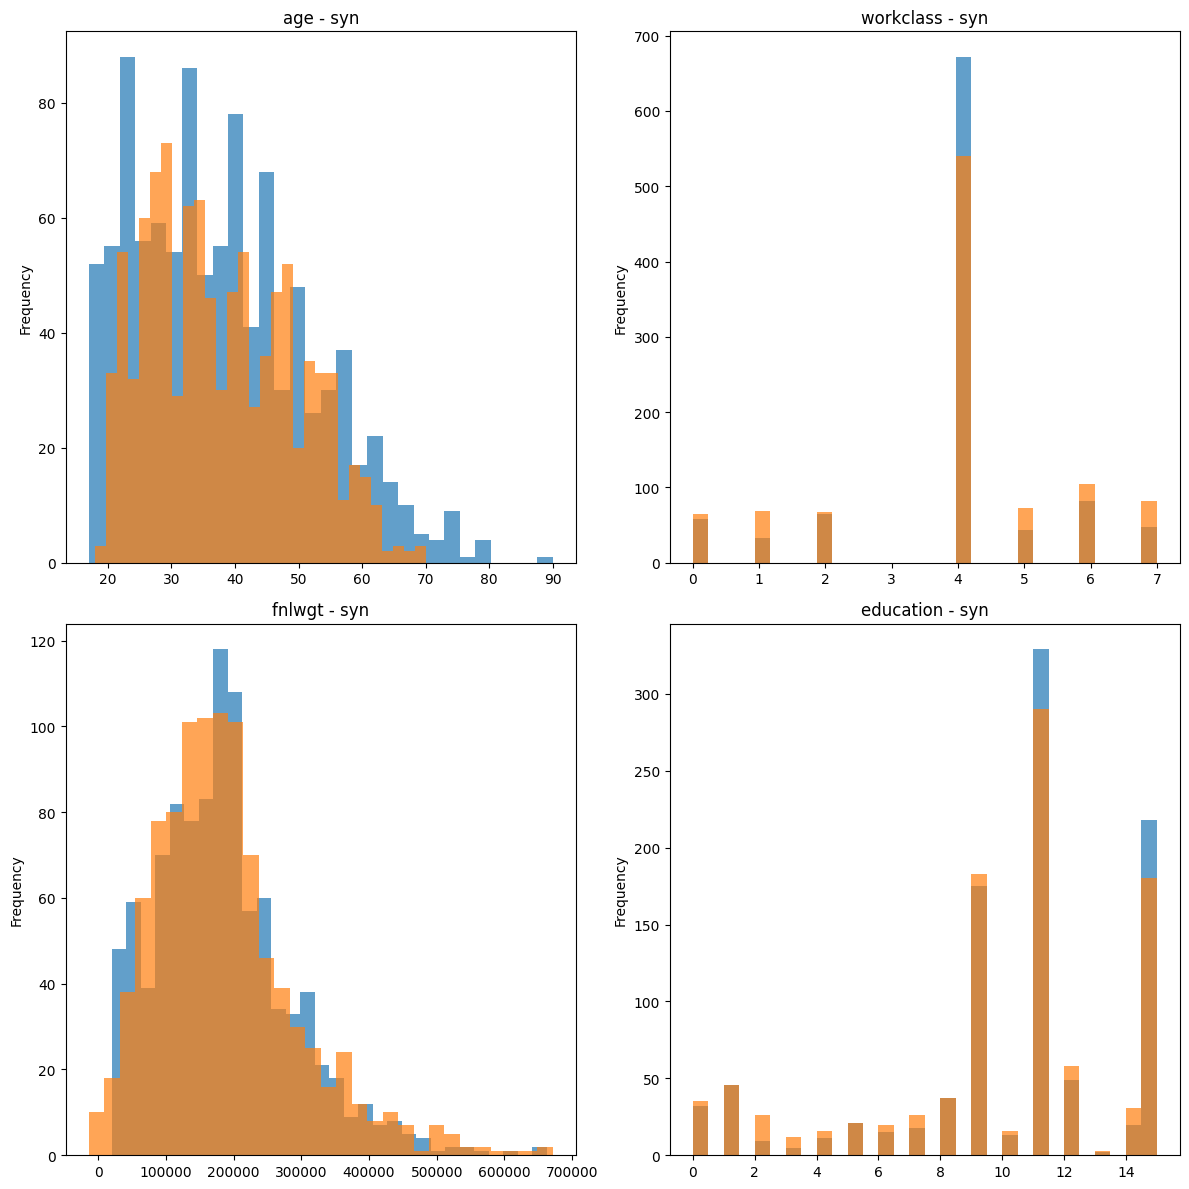

In [6]:
import matplotlib.pyplot as plt

# Create subplots dynamically based on the number of columns
num_cols = len(df.columns)
num_rows = (num_cols + 1) // 2  # Ensure enough rows for the number of columns

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 12))

# Flatten axes into a 1D array for easier indexing
axes = axes.ravel()

for i, column in enumerate(df.columns):
    df[column].plot(kind='hist', ax=axes[i], title=f'{column} - df', bins=30, alpha=0.7)
    syn[column].plot(kind='hist', ax=axes[i], title=f'{column} - syn', bins=30, alpha=0.7)

plt.tight_layout()
plt.show()



In [7]:

from model.eval.evaluation import stat_sim

stat_sim(df,syn, ["workclass"])


column:  age WD:  0.022452054794520546
column:  workclass JSD:  0.13142472152061696
column:  fnlwgt WD:  0.009251167947775606
column:  education WD:  0.030733333333333328


[np.float64(0.02081218535854316),
 np.float64(0.13142472152061696),
 np.float64(0.2496007792508759)]

In [8]:
from model.eval.evaluation import privacy_metrics
privacy_metrics(df,syn)

==== Privacy Metrics Analysis ====
Using 15% of data for analysis
Real data sample size: 150
Fake data sample size: 150

Calculating pairwise distances...

== Nearest Neighbor Ratio Metrics (5th percentile) ==
Real-to-Real NN Ratio (5th): 0.2075
Fake-to-Fake NN Ratio (5th): 0.2721
Real-to-Fake NN Ratio (5th): 0.3394

== Minimum Distance Metrics (5th percentile) ==
Real-to-Fake Min Distance (5th): 0.0069
Real-to-Real Min Distance (5th): 0.0044
Fake-to-Fake Min Distance (5th): 0.0110

Privacy Risk Score: 0.8930
(Higher score indicates better privacy protection)

==== Summary Interpretation ====
⚠ Synthetic records may be too similar to real data
✓ Good neighbor distance ratios


{'nn_ratio_rr_5th': np.float64(0.20752493501166897),
 'nn_ratio_ff_5th': np.float64(0.2720886410292328),
 'nn_ratio_rf_5th': np.float64(0.3393725371352108),
 'min_dist_rf_5th': np.float64(0.006858773532397353),
 'min_dist_rr_5th': np.float64(0.004381354322202362),
 'min_dist_ff_5th': np.float64(0.010980441864812835),
 'privacy_risk_score': np.float64(0.8929650476934256),
 'metrics_array': array([[0.00685877, 0.00438135, 0.01098044, 0.33937254, 0.20752494,
         0.27208864]])}